## Similarity Search using VITs

In [1]:
from transformers import AutoFeatureExtractor, AutoModel
model_checkpoint = "google/vit-base-patch16-224-in21k"
extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)

hidden_dim = model.config.hidden_size

### Read the dataset from images

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="jewelry_images", )

In [99]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

dataset = dataset.map(transforms, batched=True)

Map:   0%|          | 0/3406 [00:00<?, ? examples/s]

In [101]:
dataset.save_to_disk('jewelry_images_processed')

Saving the dataset (0/1 shards):   0%|          | 0/3406 [00:00<?, ? examples/s]

### Read the dataset from disk

In [197]:
from datasets import load_from_disk
dataset = load_from_disk('jewelry_images_processed')

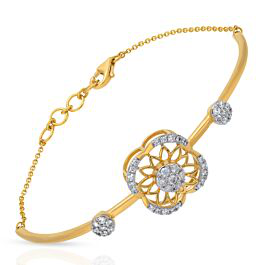

In [100]:
dataset['train'][0]['image']

In [102]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [136]:
candidate_subset = dataset["train"]

In [137]:
# num_samples = 100
# seed = 42
# candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

### Embeddings

In [138]:
import torchvision.transforms as T

transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size)),
        T.CenterCrop(extractor.size),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [139]:
import torch

def extract_embeddings(model: torch.nn.Module):
    device = model.device

    def pp(batch):
        images = batch["image"]

        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/3406 [00:00<?, ? examples/s]

In [140]:
from tqdm.auto import tqdm
candidate_ids = []
for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["label"]
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

  0%|          | 0/3406 [00:00<?, ?it/s]

In [141]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [142]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

In [181]:
def fetch_similar(image, top_k=10):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]
    scores = list(similarity_mapping_sorted.values())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels, scores

In [182]:
test_idx = np.random.choice(len(dataset["train"]))
test_sample = dataset["train"][test_idx]["image"]
test_label = dataset["train"][test_idx]["label"]

sim_ids, sim_labels, sim_scores = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")
print(f"Top 5 candidate Scores: {sim_scores}")

Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Top 5 candidate Scores: [0.9999999999995984, 0.8099198332098576, 0.8075150147461003, 0.8038015395839423, 0.7970241839735801, 0.7954618563979092, 0.7926568580223263, 0.7897656204627681, 0.7871881458199599, 0.7868242423455531]


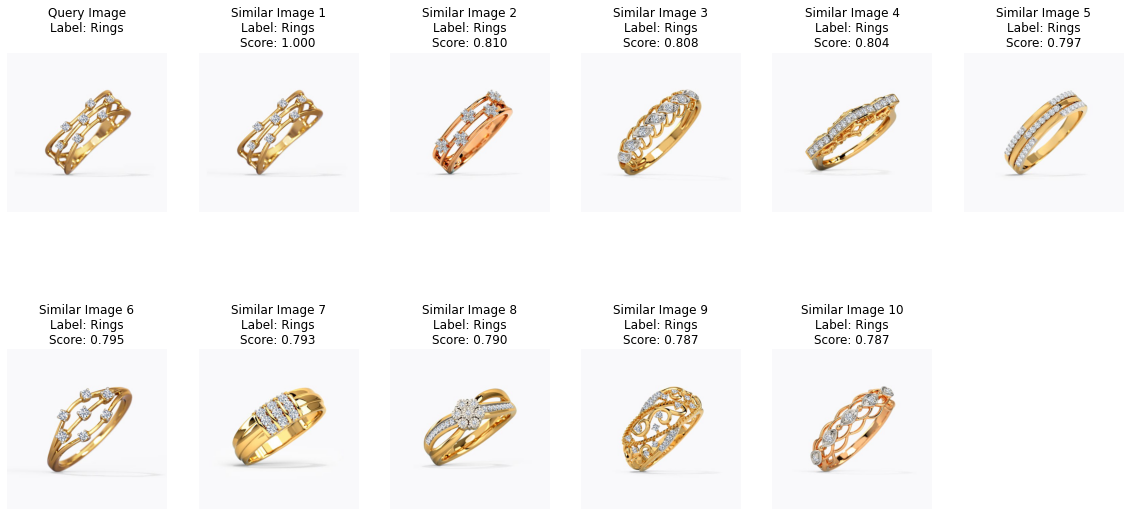

In [195]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + f"Label: {id2label[label_id]}\n")
        else:
            ax.set_title(
                "Similar Image " + str(i) + f"\nLabel: {id2label[label_id]}"+ f"\nScore: {sim_scores[i - 1]:.3f}"
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

### Attention Map